<a href="https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/ML_journal_club_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST HANDWRITTEN DIGIT CLASSIFICATION WITH PYTORCH

This notebook follows [`TORCH.NN`](https://pytorch.org/tutorials/beginner/nn_tutorial.html) tutorial. If you are not familiar with `PyTorch`, you can read "[What is PyTorch?](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)" and "[Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)" tutorials from "[Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)" to get a quick overview of PyTorch.

---





It is assumed that you are either running this notebook in Google [colab](https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/ML_journal_club_01.ipynb), or you have already downloaded and locally installed [`pytorch`](https://pytorch.org/get-started/locally/) and all other required packaged to run this notebook on your computer (as long as you have `pytorch`, you can install other packages as you go along).


**Additional resources**:
- "Deep Learning" course: course notes with `PyTorch` codes (Alfredo Canziani, NYU) [[website](https://atcold.github.io/pytorch-Deep-Learning/)] [[notebooks](https://github.com/Atcold/pytorch-Deep-Learning)]
- "Practical Deep Learning for Coders v3": deep NN models are implemented in `PyTorch` (`fast.ai`) [[website](https://course.fast.ai)]


In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Check for CUDA-enabled GPUs, or else use CPU:

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


## Download and Import the Datasets

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
# Training and testing datasets
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

# Comvert to torch tensor
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(f'Training set\n# samples : {x_train.shape[0]}\nx shape : {x_train.shape}',
      f'\ny shape : {y_train.shape}')
print(f'\nValidation set\n# samples : {x_valid.shape[0]}\nx shape : {x_valid.shape}')

Training set
# samples : 50000
x shape : torch.Size([50000, 784]) 
y shape : torch.Size([50000])

Validation set
# samples : 10000
x shape : torch.Size([10000, 784])


## Display MNIST Samples from "Training" and "Validation" Datasets

* Let's plot some randomly selected examples

In [5]:
np.random.seed(42)
sample_ids = np.random.randint(x_valid.shape[0],size=(5,))
print(f'We will plot samples {sample_ids} from "training" and "validation" datasets.')

We will plot samples [7270  860 5390 5191 5734] from "training" and "validation" datasets.


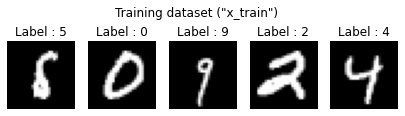

In [6]:
_, axs = plt.subplots(ncols=5,figsize=[7,2])

for ax,t in zip(axs,sample_ids):
  ax.imshow(x_train[t,:].reshape(28,28),cmap='gray')
  ax.set_title(f'Label : {y_train[t]}')
  ax.axis(False)
plt.suptitle(f'Training dataset ("x_train")');
plt.show()

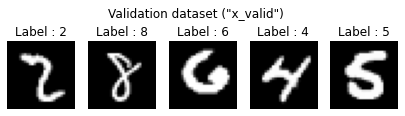

In [7]:
_, axs = plt.subplots(ncols=5,figsize=[7,2])

for ax,t in zip(axs,sample_ids):
  ax.imshow(x_valid[t,:].reshape(28,28),cmap='gray')
  ax.set_title(f'Label : {y_valid[t]}')
  ax.axis(False)
plt.suptitle('Validation dataset ("x_valid")');
plt.show()

## Converting Labels to One-hot Encoding in Pytorch

Although some loss functions can handle labels in their raw form (e.g. $y_i$ = "1"), in its general form multiclass classifier requires us to encode target labels (those we provide during the training) into one-hot encoding format. In pytorch, we can use `scatter` function for one-hot encoding MNIST labels.
- Technically, all loss functions internally have to represent target and predicted labels as one-hot encoded vectors.
- E.g. one-hot encoded labels for digits "1" and "5" are as follows
  - "1": `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`, and 
  - "5": `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`

In [8]:
y_hot = torch.FloatTensor(2,10) # initialise batch labels (done once outside the for-loop)
y_hot.zero_() # set them to zero (for each iter-n)
y_hot.scatter_(1,torch.tensor([[1],[4]]),1) # encode labels "1" and "4"
y_hot

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [9]:
D_in =  28*28
D_out = 10 # number of classes
W = torch.zeros((D_in,D_out))
b = torch.ones((1,D_out))*.1

torch.mm(torch.rand((5,D_in)),W)+b

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])

## Softmax Classifier w/o `TORCH.NN`

$$C_i = softmax(W\cdot X_i + b)$$

where softmax function with output $C_i\in \mathbb{R}^{K}$ , for $K$ classes

$$softmax(z_i) = \frac{e^{z_i}}{\sum^K_{j=1} e^{z_j}}$$

- $X_i$ input (flattened) image, 784x1 array
- $C_i$ predicted class of the image (label), e.g. "4", $C_i$ is a $K$-dimensional vector (one-hot encoding).
- $W\in\mathbb{R}^{10\times784}, b\in\mathbb{R}^{10}$ are learnable model parameters
[[more about softmax and other classifiers](https://cs231n.github.io/linear-classify/#softmax)] (below we will be using $W^T$ with multiple examples from the dataset $X$, called mini-batch or batch, but otherwise the model definition is equivalent)

Same as the tutorial we use $log(C_i)$ ("log-of-softmax") in the model. If you want to convert the values into probabilities you need to take exponential of the model output.

In [`torch.nn`](https://pytorch.org/tutorials/beginner/nn_tutorial.html) tutorial author uses Xavier initialisation ([Glorot & Bengio 2010](http://proceedings.mlr.press/v9/glorot10a)) for initialising the weights. Since it is a _single layer network_ we could get away with sampling $W_{ij}$ from standard normal or uniform distributions.

However, we do need to be careful when we initialise our network parameters. Incorrect initialisation leads to a slower training due to exploding (large $|W_{ij}|$) and/or zero ($W_{ij}\approx 0$) gradients. This is especially true for deep models, and choice of the initialisation method depends on the activation function.

`PyTorch` comes with many initialisation methods already implemented with helpful documentation and usage examples in its [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html) module.

### Model Parameters

- When init-g parameters we need to set `requires_grad` flag of the `pytorch` tensor to `True`. This enables `autograd` to keep track of the gradients w.r.t. the param-s

In [36]:
# Standard normal
weights = torch.randn(784, 10).to(device)

# With Xavier:
# weights = torch.randn(784, 10).to(device)*np.sqrt(2)/np.sqrt(784+10)

print(f'weights.requires_grad: {weights.requires_grad}')
weights.requires_grad_() #sets requires_grad flag to True
print(f'weights.requires_grad: {weights.requires_grad}')

weights.requires_grad: False
weights.requires_grad: True


In [0]:
#enable grad tracking at tensor init-n
bias = torch.zeros(10, requires_grad=True, device=device)

### Model
- Softmax classifier

In [0]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xbatch):
  return log_softmax(xbatch @ weights + bias)

In [39]:
bs = 8  # batch size

xb = x_train[0:bs].to(device)  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3873e+01, -9.3209e+00, -2.0566e+01, -1.6471e+01, -2.0073e+01,
        -1.9398e+01, -1.3134e+01, -1.2125e-02, -4.4262e+00, -2.2347e+01],
       device='cuda:0', grad_fn=<SelectBackward>) torch.Size([8, 10])


- Note the `grad_fn` and `device`.

### Loss Function
- _negative log-likelihood_ (w/o using one-hot encoding)

_See also_ [`torch.nn.NLLLoss`](https://pytorch.org/docs/stable/nn.html#nllloss), and other `torch.nn` [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [0]:
def nll(ypred, target):
    return -ypred[range(target.shape[0]), target].mean()

loss_func = nll

In [41]:
yb = y_train[0:bs].to(device)
print(loss_func(preds, yb))

tensor(15.8465, device='cuda:0', grad_fn=<NegBackward>)


- Accuracy

In [0]:
def accuracy(ypred, ytarget):
    preds = torch.argmax(ypred, dim=1)
    return (preds == ytarget).float().mean()

In [43]:
print(accuracy(preds, yb))

tensor(0.1250, device='cuda:0')


Notes on debugging classifiers:
- Since we have 10 output classes, even a random model, that guesses outputs randomly, should have roughly 10% accuracy.

### Training Loop

In [0]:
# from IPython.core.debugger import set_trace

# Set gradients to zeros
if weights.grad is not None:
  weights.grad.zero_()
  bias.grad.zero_()

bs = 64 # batch size
lr = 0.5 # learning rate (step size)

epochs = 2  # how many epochs to train for
# Epochs: number of times to go through the whole dataset
n = x_train.shape[0]

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i].to(device)
        yb = y_train[start_i:end_i].to(device)
        pred = model(xb)
        loss = loss_func(pred.to(device), yb.to(device))

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [64]:
# Loss/Acc for the latest batch
print(f'Loss (NLL): {loss_func(model(xb), yb)}\n'+
      f'Accuracy : {accuracy(model(xb), yb)*100}%')

Loss (NLL): 0.04381337761878967
Accuracy : 100.0%


In [0]:
# What is the average loss and accuracy for the whole training/validation dataset?


What did our linear model learn? Spoiler-- templates.

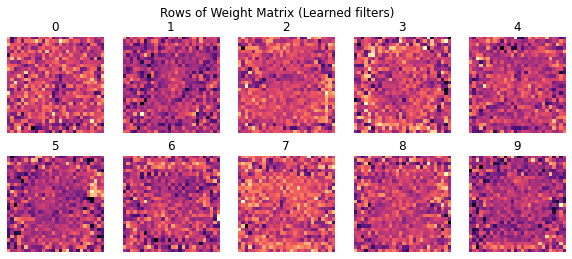

In [60]:
_, axs = plt.subplots(ncols=5,nrows=2,figsize=[10,4])

for k,ax in enumerate(axs.ravel()):
  Wrow= weights[:,k].detach().cpu().numpy().reshape(28,28)
  ax.imshow(Wrow,cmap='magma')
  ax.set_title(f'{k}')
  ax.axis(False)
plt.suptitle('Rows of Weight Matrix (Learned filters)');
plt.show()

Let's train this model a little bit more

In [0]:
# Set gradients to zeros
if weights.grad is not None:
  weights.grad.zero_()
  bias.grad.zero_()

lr = 0.5 # learning rate (step size)

epochs = 30  # how many epochs to train for
# Epochs: number of times to go through the whole dataset

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i].to(device)
        yb = y_train[start_i:end_i].to(device)
        pred = model(xb)
        loss = loss_func(pred.to(device), yb.to(device))

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [0]:
print(f'Loss (NLL): {loss_func(model(xb), yb)}\n'+
      f'Accuracy : {accuracy(model(xb), yb)*100}%')

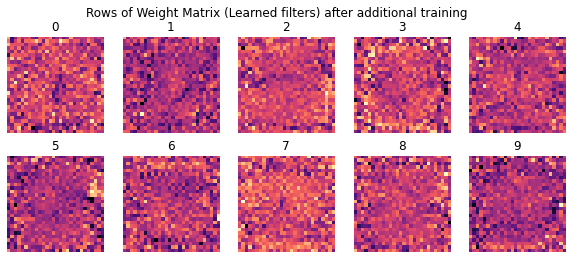

In [59]:
#after longer training
_, axs = plt.subplots(ncols=5,nrows=2,figsize=[10,4])

for k,ax in enumerate(axs.ravel()):
  Wrow= weights[:,k].detach().cpu().numpy().reshape(28,28)
  ax.imshow(Wrow,cmap='magma')
  ax.set_title(f'{k}')
  ax.axis(False)
plt.suptitle('Rows of Weight Matrix (Learned filters) after additional training');
plt.show()

You can also try running this code with Xavier init-n. Take note of the loss and acc. for the same conditions.

## Softmax Classifier with `TORCH.NN`


### `nn.functional`: From Loss Functions to Your Own Layer Definitions

Here we will simplify our code by using `nn.functional` module (copied from `nn` tutorial)
- Loss functions [docs](https://pytorch.org/docs/stable/nn.functional.html#loss-functions)

In the code below we will use [cross entropy loss](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy):
$$loss(y_{pred},\mathbf{t}) = -log\left(\frac{exp(y_{pred}[\mathbf{t}])}{\sum_j exp(y_{pred}[j])}\right)$$
Since `nn.functional.cross_entropy` combines `log_softmax` and `nll_loss`, we will have to re-write our model (we no longer need the "log-softmax" in the model, now it's moved to the loss function).

`nn.functional` also provides wide range of filters and functions, e.g.:
- Convolutional filters [[docs](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d)]
- Dropout functions [[docs](https://pytorch.org/docs/stable/nn.functional.html#dropout-functions)]
- Functions for working with images [[docs](https://pytorch.org/docs/stable/nn.functional.html#vision-functions)]
- and more!

_These functions can be used when you want to define your own more complex function or neural network layers._

In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias # no log-softmax

The loss value should be the same as before

In [67]:
print(f'Loss (NLL): {loss_func(model(xb), yb)}\n'+
      f'Accuracy : {accuracy(model(xb), yb)*100}%')

Loss (NLL): 0.043813347816467285
Accuracy : 100.0%


### `nn.Module`: Base Class for Higher-level Layer and Model Definitions



Although you could directly define shallow models with [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#sequential) (or similar `nn` classes called [containers](https://pytorch.org/docs/stable/nn.html#containers), e.g. "module list"), for more complex models it is more convenient to inherent from `nn.Module` base-class (also a container) and define complex layers and models. E.g.
```python
class Special_Layer(nn.Module):
  # you can use other containers here
  ...
```
> and then use this layer in another layer or model:

```python
class My_Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # some layer definitions
    self.special = Special_Layer(layer_params)
    ...
  def forward(self, x):
    x = F.relu(self.special(x))
    ...
    return x
```

We need to convert our `weights` and `bias` param-s into `nn.Parameter` tensor. `Parameter` tensor allows `nn.Module` to automatically keep track of the model param-s (as long as they are `Module` attributes) and can be used with `nn.Module` convenience functions such as [`self.parameters()`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.parameters). This allows us to keep temporary variables in the model w/o registering them as `Parameter` tensor.

In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias